# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Tuning

***

**What is the objective of this file?**

To process the datasets to make it suitable for use in Model Training and Model Evaluation.

## Checklist

- Ensure that you have installed the necessary libraries needed to execute the training process. 
- You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 0. Preparations

In [1]:
#Python Libraries
import time, threading, math
from datetime import datetime

#Data/Dataset libraries
import pandas as pd
import numpy as np

#Split Sampler/Data Splitting
from sklearn.model_selection import train_test_split

#Oversampler
from imblearn.over_sampling import SMOTEN

#Label Encoding
from sklearn.preprocessing import LabelEncoder

#Timer
start = end = 0
LOG_FILENAME = "Dataset_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    global DATASET_FILENAME
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{DATASET_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

# 1. Import Datasets

**Notice:** 
1. Make sure check the value of line 3 of the block below before running.
2. A backup of the processed datasets is already found in `/Processed Datasets` folder. Simply unzip it to replace the contents of `/Processed Datasets/IB` and `/Processed Datasets/TB` folders.

In [2]:
#Filenames
filename = ["oliveira_lite.csv", "oliveira.csv"]
DATASET_FILENAME = filename[0] # <== CHANGE THIS ACCORDINGLY
API_LIST = "api_calls.txt"

#Load list of API calls
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

#Importing Datasets
oli = pd.read_csv(DATASET_FILENAME)
print("Oliveira Info:")
oli.info()

Oliveira Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 2.0+ MB


In [3]:
#Previewing Dataset
oli.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,5b51d65972a349f90a86984c26b12b30,286,110,172,240,117,240,117,240,117,...,215,114,215,117,261,106,144,297,117,0
1,ceb8cc125478fad641daa4e04e9b2f19,198,208,106,271,144,194,257,127,114,...,215,86,215,172,117,215,86,215,297,0
2,f108600edf46d7c20f6acc522aeba6df,82,228,16,29,82,29,82,29,82,...,286,73,286,208,286,73,286,257,114,0
3,711be6337cb78a948f04759a0bd210ce,82,240,117,240,117,240,117,240,117,...,117,208,117,35,240,117,35,208,240,0
4,6de26f67ceb1e3303b889489010f4c3f,286,110,172,240,117,240,117,240,117,...,215,114,215,117,71,25,71,275,260,0


In [4]:
print("Oliveira Label Counts")
print("0 as Benign, 1 as Malicious")
oli.malware.value_counts()

Oliveira Label Counts
0 as Benign, 1 as Malicious


malware
1    2540
0      70
Name: count, dtype: int64

Oliveira Unique API calls list


<Axes: title={'center': "Top 20 API calls in 'Oliveira'"}>

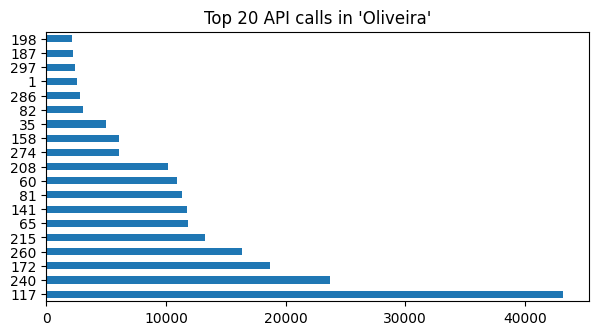

In [5]:
print("Oliveira Unique API calls list")
oli_unique = pd.Series(oli[list(oli.columns.values)[2:]].values.ravel())
oli_unique.sort_values(inplace=True, ascending=False)
oli_unique.value_counts()[0:19].plot(kind='barh', figsize=(7,3.5), title='Top 20 API calls in \'Oliveira\'') #Top 20 only

In [6]:
oli_unique.unique()

array([306, 305, 303, 302, 301, 298, 297, 295, 294, 293, 292, 291, 290,
       288, 287, 286, 285, 284, 283, 280, 278, 277, 275, 274, 271, 270,
       268, 267, 266, 264, 263, 262, 261, 260, 259, 258, 257, 256, 255,
       254, 253, 252, 251, 249, 248, 247, 245, 244, 243, 240, 239, 235,
       234, 232, 230, 228, 226, 225, 224, 222, 221, 220, 218, 217, 216,
       215, 214, 213, 212, 211, 210, 209, 208, 207, 206, 202, 201, 200,
       199, 198, 197, 196, 194, 192, 190, 187, 185, 183, 181, 180, 178,
       177, 176, 175, 174, 173, 172, 171, 170, 168, 166, 165, 164, 162,
       160, 159, 158, 157, 156, 154, 153, 151, 149, 148, 147, 145, 144,
       143, 142, 141, 140, 135, 133, 131, 129, 128, 127, 125, 123, 122,
       121, 120, 119, 118, 117, 114, 113, 112, 111, 110, 109, 108, 106,
       104, 103, 100,  99,  97,  95,  94,  93,  92,  91,  90,  89,  88,
        87,  86,  85,  84,  83,  82,  81,  80,  79,  77,  76,  75,  74,
        73,  72,  71,  70,  68,  67,  65,  64,  63,  62,  60,  5

# 2. Dataset Preparation

## 2.1. Dataset Cleaning and Dataset Formatting

In [7]:
#Removing hash column
hash_col = oli.pop('hash')
#Re-arranging column positions
label_col = oli.pop('malware')
oli = pd.concat([label_col, oli], axis=1)

oli

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,0,286,110,172,240,117,240,117,240,117,...,297,215,114,215,117,261,106,144,297,117
1,0,198,208,106,271,144,194,257,127,114,...,117,215,86,215,172,117,215,86,215,297
2,0,82,228,16,29,82,29,82,29,82,...,73,286,73,286,208,286,73,286,257,114
3,0,82,240,117,240,117,240,117,240,117,...,240,117,208,117,35,240,117,35,208,240
4,0,286,110,172,240,117,240,117,240,117,...,297,215,114,215,117,71,25,71,275,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,141
2606,1,112,274,158,215,274,158,215,298,76,...,117,71,297,135,171,215,35,208,56,71
2607,1,82,240,117,240,117,240,117,240,117,...,240,117,240,117,82,172,117,16,31,215
2608,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,141


## 2.2. Inverse Data Encoding

*Encoded API calls to String API Calls*

In [8]:
#Inverse Label Encoding
def inverse_label(item):
    global APIS
    return item.map(lambda x: APIS[int(x)])
start_time()
oli.iloc[:, 1:] = oli.iloc[:, 1:].apply(inverse_label, axis=1, result_type='reduce')
end_time("Inverse Data Encode")

oli.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,0,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtCreateFile,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,CoCreateInstance,NtOpenSection,CreateDirectoryW,NtCreateFile,LdrGetProcedureAddress
1,0,GetSystemInfo,NtAllocateVirtualMemory,NtOpenSection,GetTempPathW,CreateDirectoryW,GetFileAttributesW,FindFirstFileExW,DeleteFileW,NtQueryDirectoryFile,...,LdrGetProcedureAddress,NtClose,NtCreateMutant,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,NtClose,NtCreateMutant,NtClose,NtCreateFile
2,0,GetSystemTimeAsFileTime,NtProtectVirtualMemory,SetUnhandledExceptionFilter,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,...,GetFileAttributesExW,SetErrorMode,GetFileAttributesExW,SetErrorMode,NtAllocateVirtualMemory,SetErrorMode,GetFileAttributesExW,SetErrorMode,FindFirstFileExW,NtQueryDirectoryFile
3,0,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,LdrLoadDll,LdrGetProcedureAddress,GetSystemMetrics,NtAllocateVirtualMemory,LdrLoadDll
4,0,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtCreateFile,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,LoadStringW,GetSystemWindowsDirectoryW,GetSystemDirectoryW,RegOpenKeyExW


Oliveira Unique API calls list


<Axes: title={'center': "Top 20 API calls in 'Oliveira'"}>

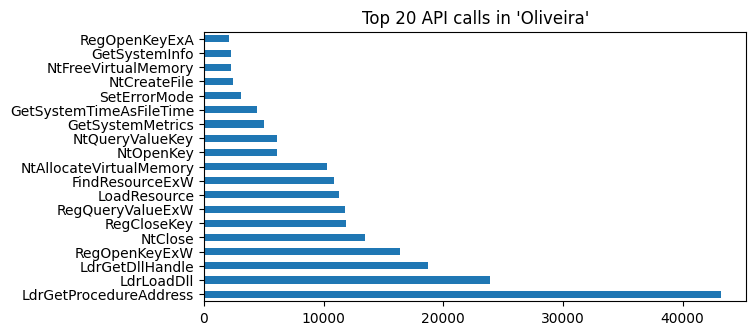

In [9]:
print("Oliveira Unique API calls list")
oli_unique = pd.Series(oli[list(oli.columns.values)[1:]].values.ravel())
oli_unique.sort_values(inplace=True, ascending=False)
oli_unique.value_counts()[0:19].plot(kind='barh', figsize=(7,3.5), title='Top 20 API calls in \'Oliveira\'') #Top 20 only

In [10]:
oli_unique.unique()

array(['timeGetTime', 'socket', 'shutdown', 'setsockopt', 'send',
       'select', 'ioctlsocket', 'getsockname', 'gethostbyname',
       'getaddrinfo', 'connect', 'closesocket', 'bind', '__exception__',
       'WriteProcessMemory', 'WriteConsoleW', 'WriteConsoleA',
       'WSAStartup', 'WSARecv', 'UuidCreate', 'UnhookWindowsHookEx',
       'Thread32Next', 'Thread32First', 'StartServiceW', 'StartServiceA',
       'SizeofResource', 'ShellExecuteExW', 'SetWindowsHookExW',
       'SetWindowsHookExA', 'SetUnhandledExceptionFilter', 'SetStdHandle',
       'SetFileTime', 'SetFilePointerEx', 'SetFilePointer',
       'SetFileAttributesW', 'SetErrorMode', 'SetEndOfFile',
       'SearchPathW', 'SHGetSpecialFolderLocation', 'SHGetFolderPathW',
       'RtlRemoveVectoredExceptionHandler',
       'RtlAddVectoredExceptionHandler', 'RemoveDirectoryW',
       'RemoveDirectoryA', 'RegSetValueExW', 'RegSetValueExA',
       'RegQueryValueExW', 'RegQueryValueExA', 'RegQueryInfoKeyW',
       'RegQueryInfoKey

## 2.3. Feature Duplicate Processing

*Building Time-based and Instance-Based Datasets*

In [11]:
TB = oli.copy(deep=True) #Time-based behavior (same as original)
IB = oli.copy(deep=True) #Instance-based behavior (to be created)

start_time()
print("Transposing IB...")
IB.transpose()
print("IB Transposed!")
print("Removing duplicates...")
print("Row:", end=" ")
for r in range(oli.shape[0]):
    #Per row (sample) removal of duplicates, thus cannot scale into the whole dataframe (which is way faster)
    row = IB.iloc[r, 1:].drop_duplicates(keep='first', inplace=False).to_list()
    IB.iloc[r, 1:] = row + ([DELIMITER]*(100-len(row)))
    if r % 100 == 0:
        print(r, end=" ")
print("\nDuplicates removed!")
print("Retransposing IB (revert)...")
IB.transpose()
print("IB Retransposed!")
end_time("Feature Duplicate Process")

Transposing IB...
IB Transposed!
Removing duplicates...
Row: 0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 
Duplicates removed!
Retransposing IB (revert)...
IB Retransposed!


19.994271

# 3. Data Splitting (1st Tranche)

In [12]:
TEST_RATIO = 0.1

def firstSplit(dataset):
    global TEST_RATIO
    X = dataset.iloc[:,1:] #Features
    y = dataset.iloc[:,0] #Labels
    return train_test_split(X, y, test_size=TEST_RATIO, random_state=1, shuffle=True)

start_time()
#Time-based
TB_Features, TB_Reserve_Features, TB_Labels, TB_Reserve_Labels = firstSplit(TB)
TB = pd.concat([TB_Labels,TB_Features], axis=1)
TB_Reserve = pd.concat([TB_Reserve_Labels, TB_Reserve_Features], axis=1)
#Instance-based
IB_Features, IB_Reserve_Features, IB_Labels, IB_Reserve_Labels = firstSplit(IB)
IB = pd.concat([IB_Labels,IB_Features], axis=1)
IB_Reserve = pd.concat([IB_Reserve_Labels, IB_Reserve_Features], axis=1)
end_time("Data Split (1st Tranche)")

print(f"TB Train Split: {str(TB.shape)}")
print(f"TB Test/Holdout Split: {str(TB_Reserve.shape)}")

print(f"IB Train Split: {str(IB.shape)}")
print(f"IB Test/Holdout Split: {str(IB_Reserve.shape)}")

TB Train Split: (2349, 101)
TB Test/Holdout Split: (261, 101)
IB Train Split: (2349, 101)
IB Test/Holdout Split: (261, 101)


# 4. Data Rebalancing (SMOTE)

## 4.1. Rebalancing Function

In [13]:
def TB_rebalance(balancer):
    global TB
    #Time-based
    print("TB Rebalance...")
    X,y = TB.iloc[:,1:],TB.iloc[:,0]
    X,y = balancer.fit_resample(X, y)
    print("TB Rebalancing Finished!")
    TB = pd.concat([y, X], axis=1)
def IB_rebalance(balancer):
    global IB
    #Instance-based
    print("IB Rebalance...")
    X,y = IB.iloc[:,1:],IB.iloc[:,0]
    X,y = balancer.fit_resample(X, y)
    print("IB Rebalancing Finished!")
    IB = pd.concat([y, X], axis=1)

## 4.2. Rebalancing

In [14]:
k = math.ceil(math.sqrt(TB.shape[0])) #General consensus is for k for KNN is k=sqrt(N) where N is the sample size.
tb_thread = threading.Thread(target=TB_rebalance, args=(SMOTEN(sampling_strategy='minority', random_state=1, k_neighbors=k),))
ib_thread = threading.Thread(target=IB_rebalance, args=(SMOTEN(sampling_strategy='minority', random_state=1, k_neighbors=k),))

start_time()
tb_thread.start()
ib_thread.start()
tb_thread.join()
ib_thread.join()
end_time("Rebalance via SMOTE")

TB Rebalance...
IB Rebalance...
IB Rebalancing Finished!
TB Rebalancing Finished!


54.551836

In [15]:
print(f"TB Train Split (Rebalanced):\n{TB['malware'].value_counts()}")
print(f"IB Train Split (Rebalanced):\n{IB['malware'].value_counts()}")

TB Train Split (Rebalanced):
malware
1    2287
0    2287
Name: count, dtype: int64
IB Train Split (Rebalanced):
malware
1    2287
0    2287
Name: count, dtype: int64


# 5. Label Encoding

In [16]:
def label_encode(offset):
    global APIS
    global ENCODED
    le = LabelEncoder()
    le.fit(APIS)
    ENCODED[offset].iloc[:,1:] = ENCODED[offset].iloc[:,1:].apply(le.transform)

ENCODED = [TB.copy(deep=True), IB.copy(deep=True), TB_Reserve.copy(deep=True), IB_Reserve.copy(deep=True)]

tb_thread = threading.Thread(target=label_encode, args=(0,))
ib_thread = threading.Thread(target=label_encode, args=(1,))
tb_test_thread = threading.Thread(target=label_encode, args=(2,))
ib_test_thread = threading.Thread(target=label_encode, args=(3,))

start_time()
tb_thread.start()
ib_thread.start()
tb_test_thread.start()
ib_test_thread.start()
tb_thread.join()
ib_thread.join()
tb_test_thread.join()
ib_test_thread.join()
end_time("Label Encode")

1.461244

# 6. Saving to File

In [17]:
def save_to_csv(dfs, filenames):
    for d in range(len(dfs)):
        dfs[d].to_csv(index=False, chunksize=100, mode='w', path_or_buf=filenames[d])

STR_FILENAMES = ['TB/TB_CATB.csv', 'IB/IB_CATB.csv', 'TB/TB_Test_CATB.csv', 'IB/IB_Test_CATB.csv']
STR_API = [TB.copy(deep=True), IB.copy(deep=True), TB_Reserve.copy(deep=True), IB_Reserve.copy(deep=True)]

ENC_FILENAMES = ['TB/TB_LGBM.csv', 'IB/IB_LGBM.csv', 'TB/TB_Test_LGBM.csv', 'IB/IB_Test_LGBM.csv']
ENC_API = ENCODED

start_time()
save_to_csv(STR_API, STR_FILENAMES)
save_to_csv(ENC_API, ENC_FILENAMES)
end_time('save_to_file')

0.768715

In [18]:
logging("\n") #Adds a spacer for next instance of logs for this.